In [41]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, X_train.shape[1] * X_train.shape[2]))
X_train = (X_train > 0).astype(np.float32)
X_test = X_test.reshape((-1, X_test.shape[1] * X_test.shape[2]))
X_test = (X_test > 0).astype(np.float32)
y_train_orig, y_test_orig = y_train, y_test
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [3]:
hidden_dims = 64
input_dims = X_train.shape[1]
input_0 = Input((input_dims,))
dense_1 = Dense(hidden_dims, activation='relu')(input_0)
dense_2 = Dense(hidden_dims, activation='relu')(dense_1)
dense_3 = Dense(hidden_dims, activation='relu')(dense_2)
dense_4 = Dense(hidden_dims, activation='relu')(dense_3)
dense_out = Dense(10, activation='softmax', kernel_initializer='he_uniform')(dense_4)
model = Model(inputs=input_0, outputs=dense_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [4]:
load_saved_model = False
if load_saved_model and os.path.exists('data/outputs/mnist_dnn_4x64_10.h5'):
    model = load_model('data/outputs/mnist_dnn_4x64_10.h5')
else:
    model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))
    model.save('data/outputs/mnist_dnn_4x64_10.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.3813 - acc: 0.8789 - val_loss: 0.1776 - val_acc: 0.9463
Epoch 2/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1579 - acc: 0.9523 - val_loss: 0.1466 - val_acc: 0.9549
Epoch 3/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1194 - acc: 0.9634 - val_loss: 0.1301 - val_acc: 0.9598
Epoch 4/10
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0984 - acc: 0.9686 - val_loss: 0.1330 - val_acc: 0.9577
Epoch 5/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0836 - acc: 0.9738 - val_loss: 0.1113 - val_acc: 0.9649
Epoch 6/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0712 - acc: 0.9770 - val_loss: 0.1079 - val_acc: 0.9669
Epoch 7/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0628 - acc: 0.9793 - val_l

In [5]:
print(model.evaluate(X_test, y_test, verbose=0))
y_pred = model.predict(X_test)

[0.11503317375211045, 0.9663]


#### Convert neural network to graph

In [6]:
N = 5000
rand_inds = np.concatenate([np.random.choice(np.where(y_test_orig == c)[0], N // 10) for c in range(10)], axis=0)
g_full, g_xs = nn2graph.dense_activations_to_graph(model, X_test[rand_inds])

In [58]:
layer_sizes = [X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
i_max = np.argmax([g.num_edges() for g in g_xs])
i_min = np.argmin([g.num_edges() for g in g_xs])
g_max = g_xs[i_max]
g_min = g_xs[i_min]
g_by_class = [[g for j, g in enumerate(g_xs) if y_test_orig[j] == i] for i in range(10)]
print('edge max label: {}'.format(y_test_orig[i_max]))
print('edge min label: {}'.format(y_test_orig[i_min]))

edge max label: 3
edge min label: 6


#### Mean weighted degree distributions per class

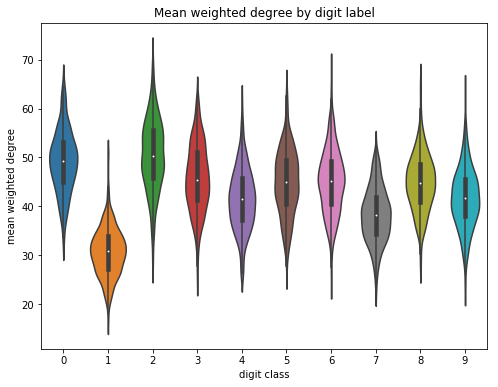

In [78]:
g_xs_mean_degree_by_class = pd.DataFrame({'digit class': y_test_orig[rand_inds],
                                          'mean weighted degree': [float(g.vp['degree'].a.mean()) for g in g_xs]})
plt.figure(figsize=(8,6))
sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class)
plt.title('Mean weighted degree by digit label')
plt.show()

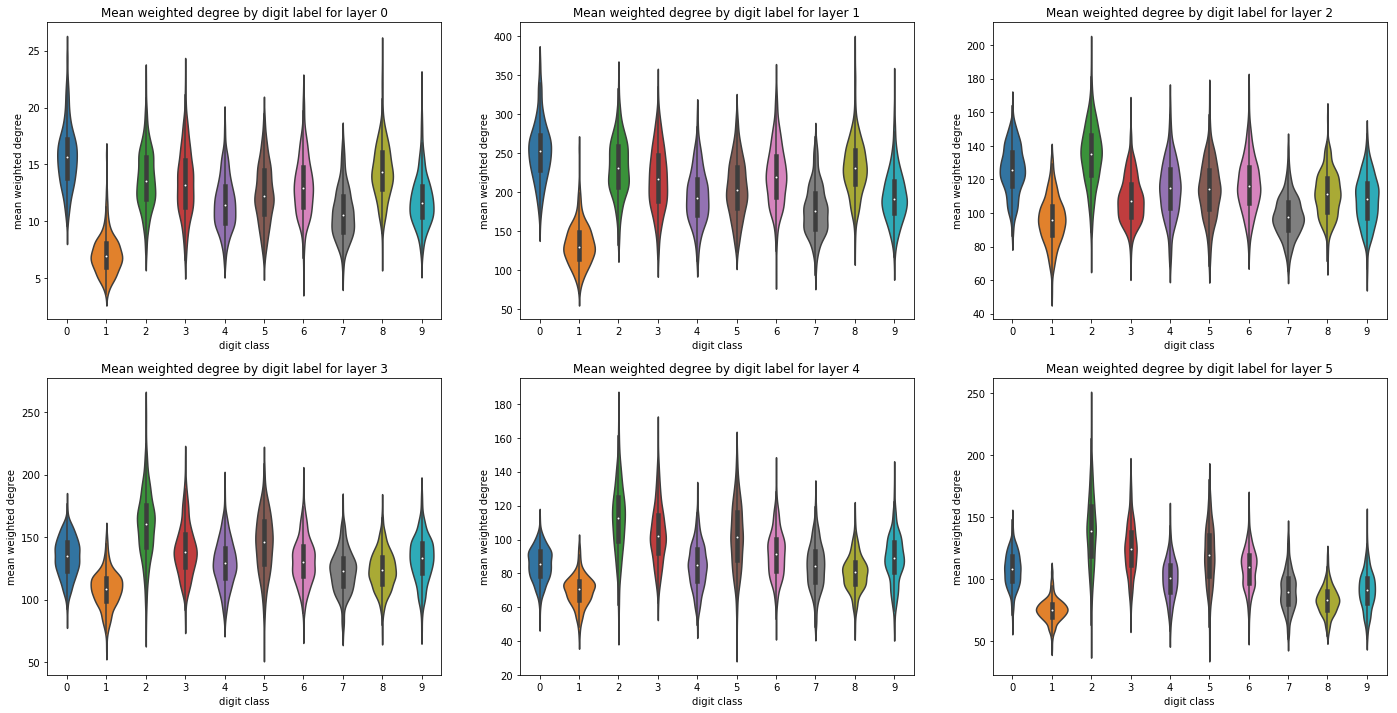

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_by_class = pd.DataFrame({'digit class': y_test_orig[rand_inds],
                                              'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class,
                   ax=ax)
    ax.set_title('Mean weighted degree by digit label for layer {}'.format(i))
plt.show()

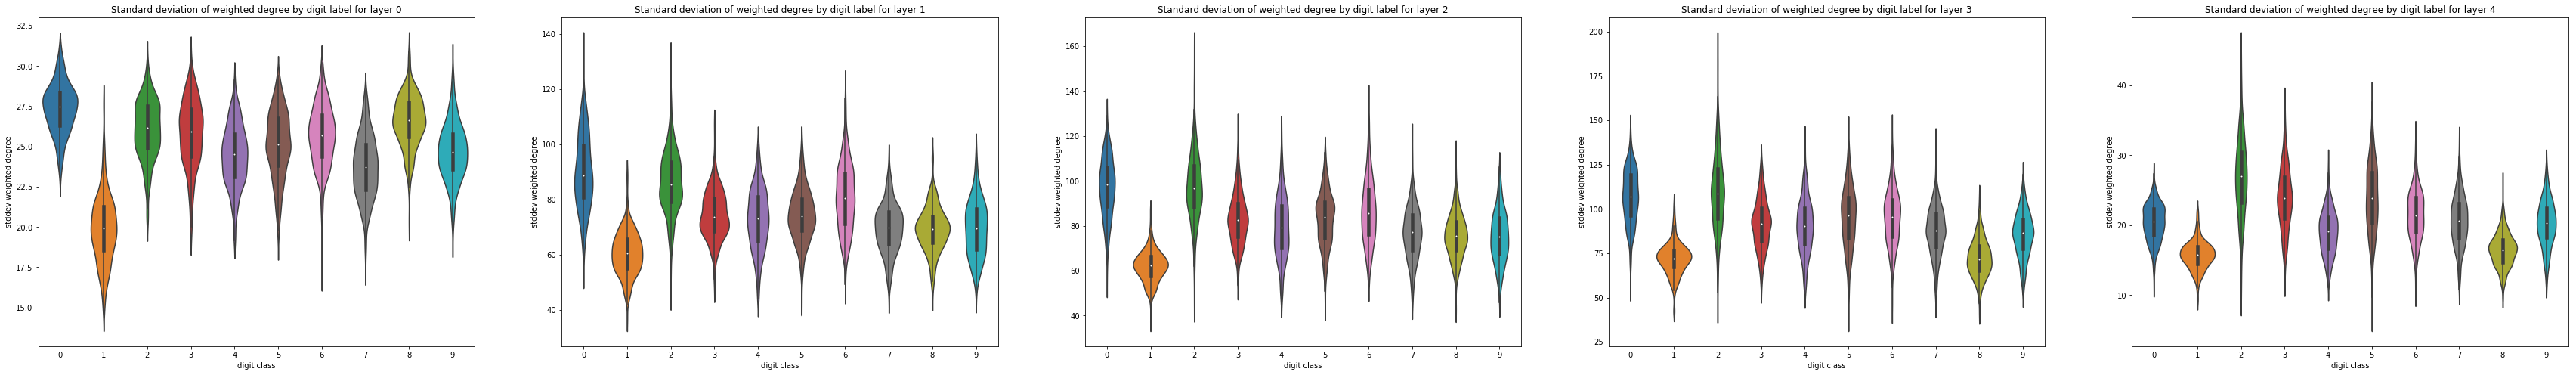

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(5*12,8))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[i]
    g_xs_std_degree_by_class = pd.DataFrame({'digit class': y_test_orig[rand_inds],
                                              'stddev weighted degree': [float(g.vp['degree'].a[st-l:st].std()) for g in g_xs]})
    sns.violinplot(x='digit class', y='stddev weighted degree', data=g_xs_std_degree_by_class,
                   ax=ax)
    ax.set_title('Standard deviation of weighted degree by digit label for layer {}'.format(i))
plt.show()

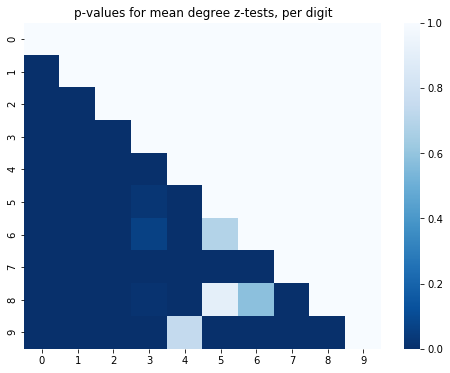

In [79]:
from statsmodels.stats.weightstats import ztest

groups_by_class = g_xs_mean_degree_by_class.groupby('digit class').groups.items()
p_vals = np.ones((10,10))
for i, (c_1, inds_1) in enumerate(groups_by_class):
    for j, (c_2, inds_2) in enumerate(groups_by_class):
        if j >= i:
            continue
        sample_1 = g_xs_mean_degree_by_class.loc[inds_1, 'mean weighted degree']
        sample_2 = g_xs_mean_degree_by_class.loc[inds_2, 'mean weighted degree']
        z, p = ztest(sample_1, sample_2)
        p_vals[i, j] = p
plt.figure(figsize=(8,6))
sns.heatmap(p_vals, cmap='Blues_r')
plt.title('p-values for mean degree z-tests, per digit')
plt.show()

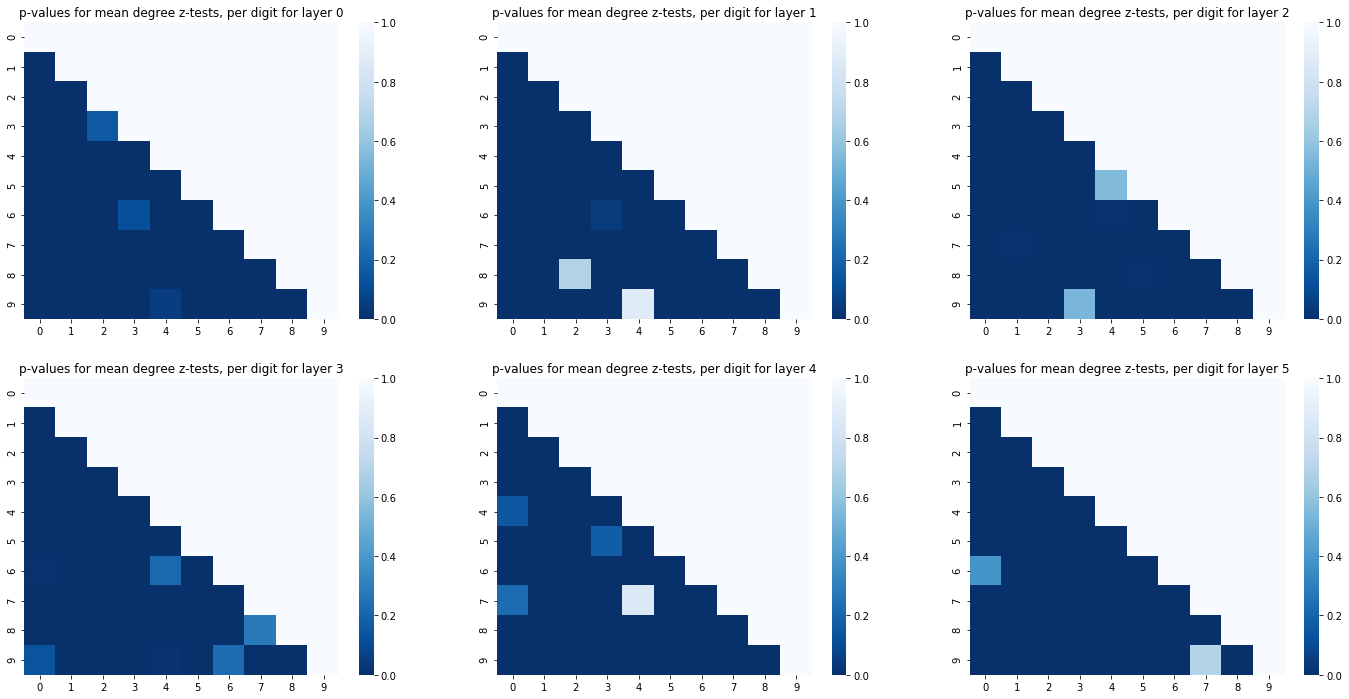

In [80]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for k, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if k < 3 else 1, k%3]
    g_xs_mean_degree_by_class_l = pd.DataFrame({'digit class': y_test_orig[rand_inds],
                                                'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    groups_by_class = g_xs_mean_degree_by_class_l.groupby('digit class').groups.items()
    p_vals = np.ones((10,10))
    for i, (c_1, inds_1) in enumerate(groups_by_class):
        for j, (c_2, inds_2) in enumerate(groups_by_class):
            if j >= i:
                continue
            sample_1 = g_xs_mean_degree_by_class_l.loc[inds_1, 'mean weighted degree']
            sample_2 = g_xs_mean_degree_by_class_l.loc[inds_2, 'mean weighted degree']
            z, p = ztest(sample_1, sample_2)
            p_vals[i, j] = p
    sns.heatmap(p_vals, cmap='Blues_r', ax=ax)
    ax.set_title('p-values for mean degree z-tests, per digit for layer {}'.format(k))
plt.show()

#### Mean weighted degrees vs number of active inputs

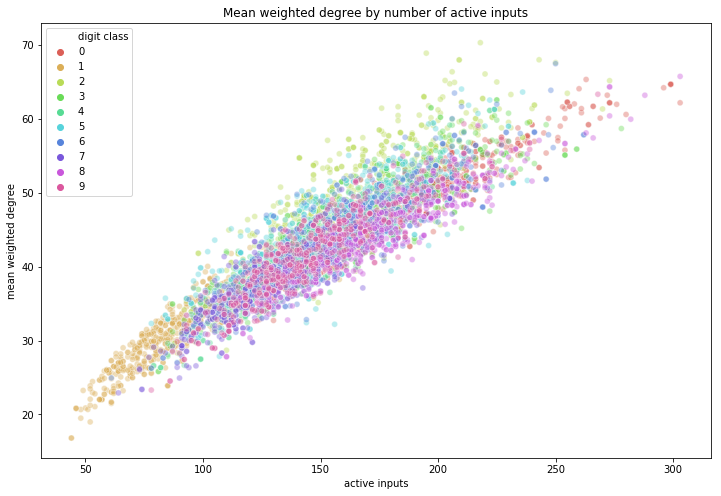

In [33]:
g_xs_degree_by_inputs = pd.DataFrame({'active inputs': np.sum(X_test[rand_inds], axis=1),
                                      'digit class': y_test_orig[rand_inds],
                                      'mean weighted degree': [float(g.vp['degree'].a.mean()) for g in g_xs]})
plt.figure(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                palette=sns.color_palette('hls', 10), alpha=0.4,
                data=g_xs_degree_by_inputs)
plt.title('Mean weighted degree by number of active inputs')
plt.show()

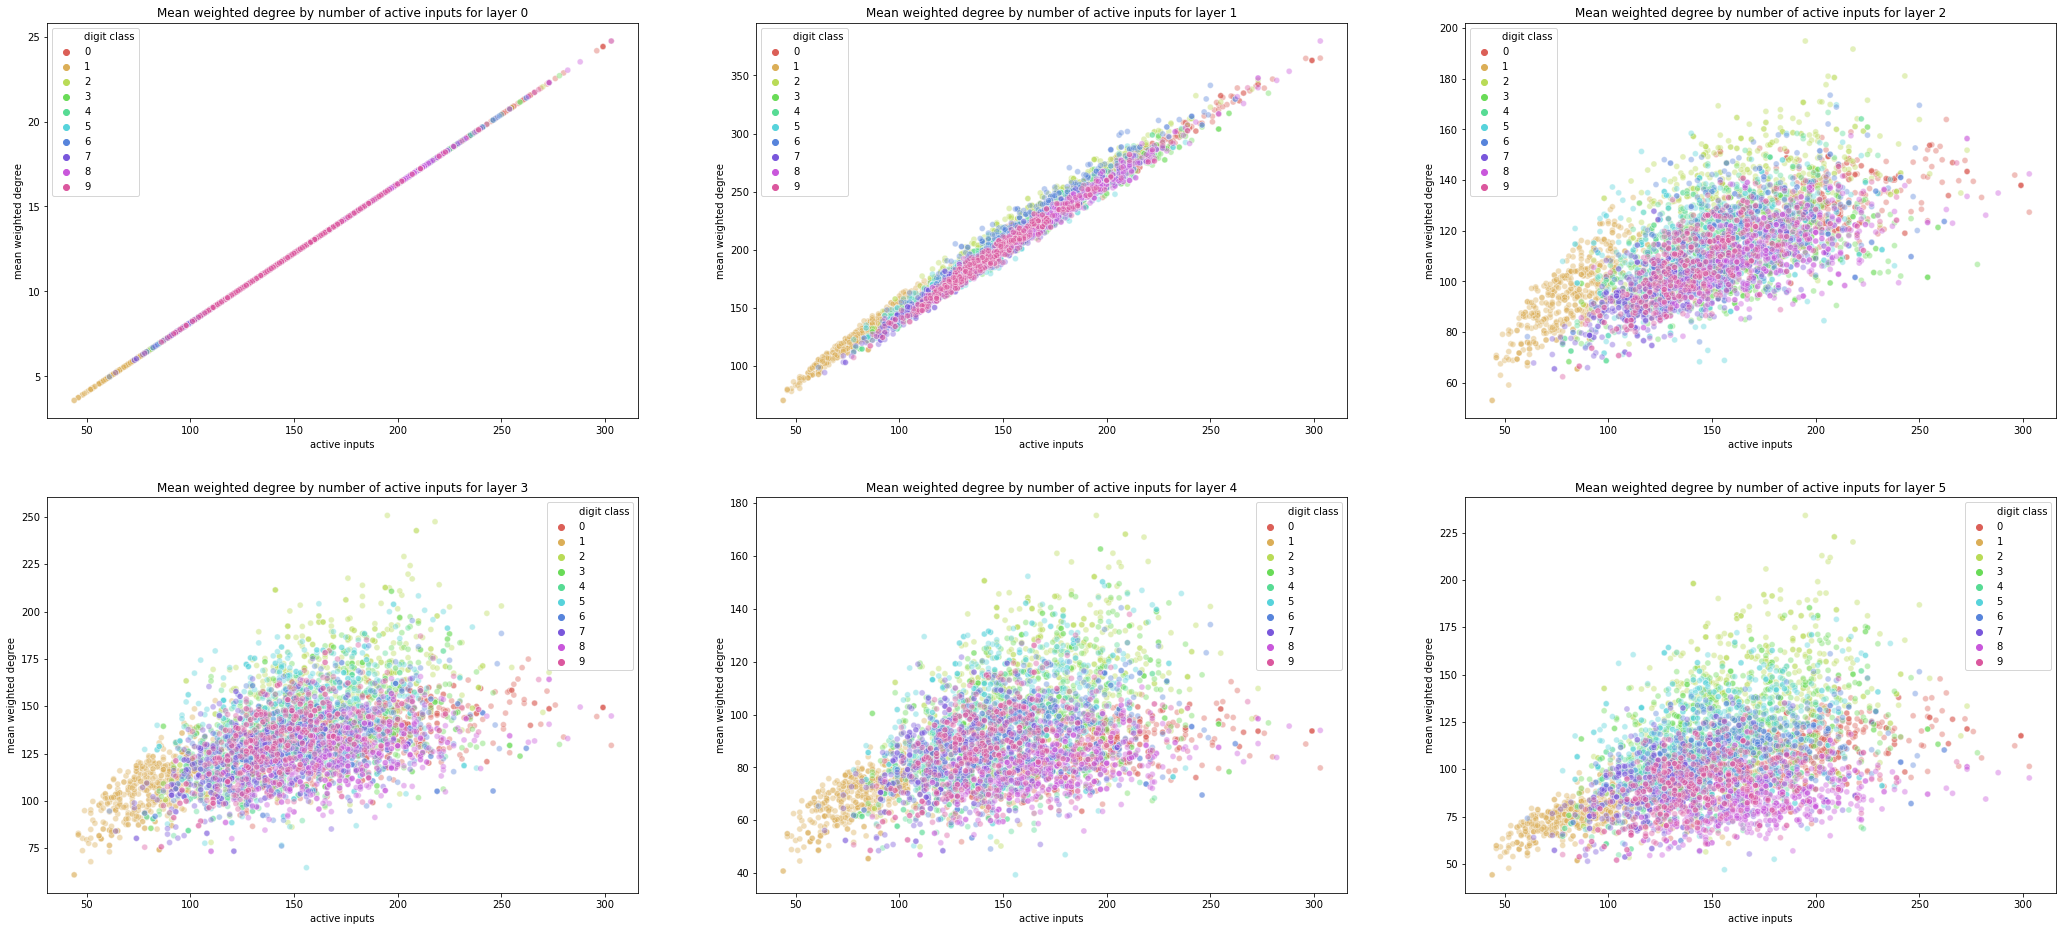

In [28]:
layer_sizes = [784, 64, 64, 64, 64, 10]
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_vs_inputs = pd.DataFrame({'active inputs': np.sum(X_test[rand_inds], axis=1),
                                               'digit class': y_test_orig[rand_inds],
                                               'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                    palette=sns.color_palette('hls', 10), alpha=0.4,
                    data=g_xs_mean_degree_vs_inputs,
                    ax=ax)
    ax.set_title('Mean weighted degree by number of active inputs for layer {}'.format(i))
plt.show()

In [10]:
from graph_tool.centrality import eigenvector
eig_max, eig_vp = eigenvector(g, weight=g.ep['weight'], max_iter=1.0E5)

In [11]:
eig_centralities = [(g.vertex_index[v], eig_vp[v]) for v in g.vertices()]

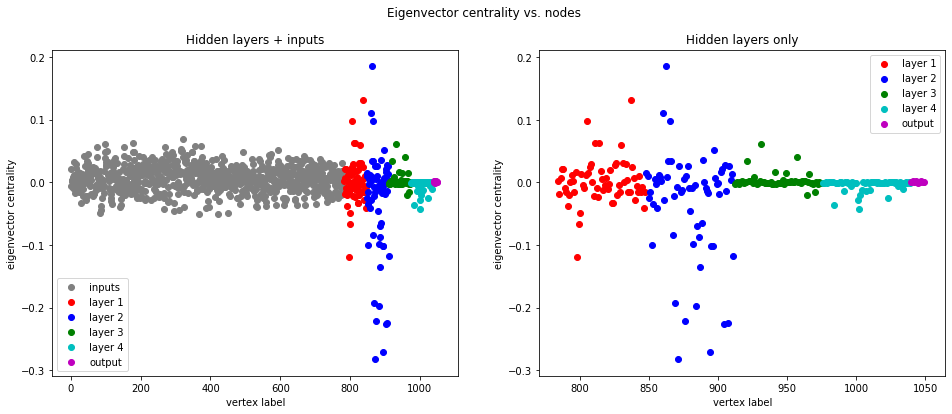

In [12]:
vs_in = [v for v,_ in eig_centralities if v < input_dims]
eigs_in = [eigc for v, eigc in eig_centralities if v < input_dims]
vs1 = [v for v,_ in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
eigs1 = [eigc for v, eigc in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
vs2 = [v for v,_ in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
eigs2 = [eigc for v, eigc in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
vs3 = [v for v,_ in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
eigs3 = [eigc for v, eigc in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
vs4 = [v for v,_ in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
eigs4 = [eigc for v, eigc in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
vs_out = [v for v,_ in eig_centralities if v >= input_dims+4*hidden_dims]
eigs_out = [eigc for v, eigc in eig_centralities if v >= input_dims+4*hidden_dims]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(vs_in, eigs_in, c='gray')
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['inputs', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('eigenvector centrality')
plt.title('Hidden layers + inputs')
plt.subplot(1,2,2)
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('eigenvector centrality')
plt.title('Hidden layers only')
plt.suptitle('Eigenvector centrality vs. nodes')
plt.show()

In [11]:
from graph_tool.centrality import katz
katz_vp = katz(g, alpha=0.1, weight=g.ep['weight'])
katz_centralities = [(g.vertex_index[v], katz_vp[v]) for v in g.vertices()]

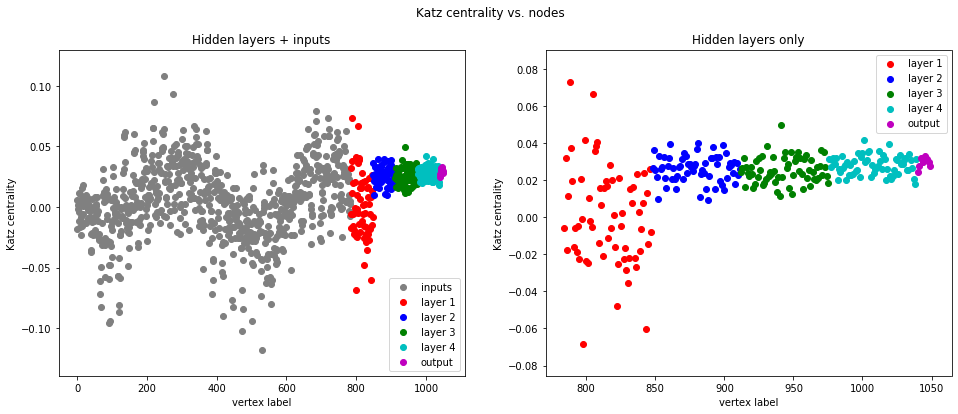

In [12]:
vs_in = [v for v,_ in katz_centralities if v < input_dims]
eigs_in = [eigc for v, eigc in eig_centralities if v < input_dims]
vs1 = [v for v,_ in katz_centralities if v >= input_dims and v < input_dims+hidden_dims]
eigs1 = [eigc for v, eigc in katz_centralities if v >= input_dims and v < input_dims+hidden_dims]
vs2 = [v for v,_ in katz_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
eigs2 = [eigc for v, eigc in katz_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
vs3 = [v for v,_ in katz_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
eigs3 = [eigc for v, eigc in katz_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
vs4 = [v for v,_ in katz_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
eigs4 = [eigc for v, eigc in katz_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
vs_out = [v for v,_ in katz_centralities if v >= input_dims+4*hidden_dims]
eigs_out = [eigc for v, eigc in katz_centralities if v >= input_dims+4*hidden_dims]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(vs_in, eigs_in, c='gray')
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['inputs', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('Katz centrality')
plt.title('Hidden layers + inputs')
plt.subplot(1,2,2)
plt.scatter(vs1, eigs1, c='r')
plt.scatter(vs2, eigs2, c='b')
plt.scatter(vs3, eigs3, c='g')
plt.scatter(vs4, eigs4, c='c')
plt.scatter(vs_out, eigs_out, c='m')
plt.legend(['layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
plt.xlabel('vertex label')
plt.ylabel('Katz centrality')
plt.title('Hidden layers only')
plt.suptitle('Katz centrality vs. nodes')
plt.show()

In [8]:
from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
min_state = minimize_nested_blockmodel_dl(g_max)
print(min_state)

<NestedBlockState object, with base <BlockState object with 8 blocks (8 nonempty), degree-corrected, for graph <GraphView object, undirected, with 1050 vertices and 21624 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f84cc6eeef0, at 0x7f84cc6f22e8>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f84cc6eeef0, at 0x7f84cc6f2358>, False) at 0x7f84cc6eeef0>, at 0x7f844025a1d0>, and 3 levels of sizes [(1050, 8), (8, 2), (2, 1)] at 0x7f844024cba8>


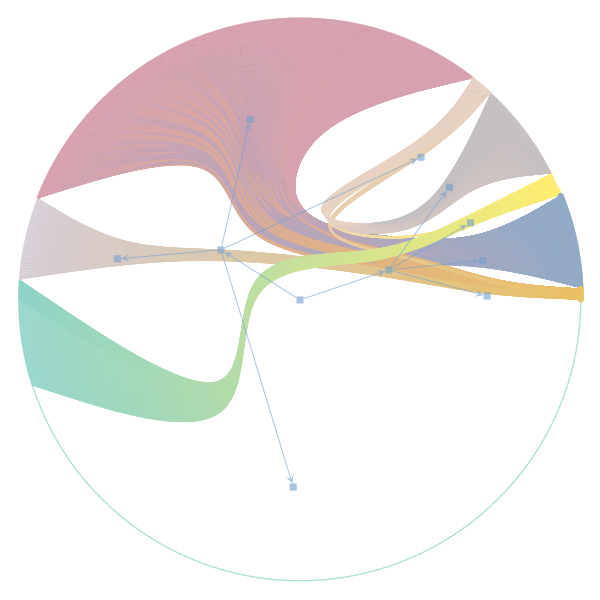

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84cc6eeef0, at 0x7f855cb65898>,
 <Graph object, directed, with 1061 vertices and 1060 edges at 0x7f855cb26cc0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f855cb26cc0, at 0x7f855cb26588>)

In [11]:
min_state.draw()

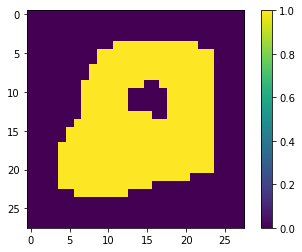

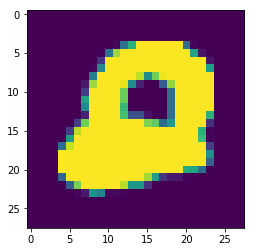

In [13]:
x = min_state.get_bs()[0]
plt.imshow(x[:784].reshape((28,28)))
plt.colorbar()
plt.show()
plt.imshow(X_test[i_max].reshape((28,28)))
plt.show()

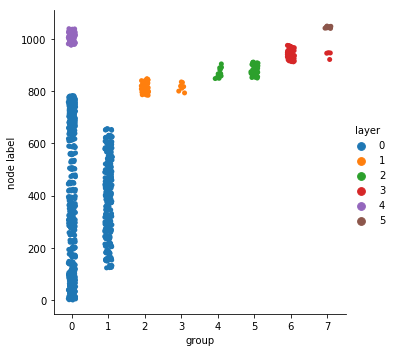

In [10]:
import pandas as pd

bs = min_state.get_bs()[0]
df = pd.DataFrame.from_dict({'group': bs, 'node label': list(range(len(bs))), 'layer': g_max.vp['layer'].a})
sns.catplot(x='group', y='node label', data=df, hue='layer')

<NestedBlockState object, with base <BlockState object with 10 blocks (10 nonempty), degree-corrected, for graph <GraphView object, undirected, with 1050 vertices and 5914 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f9c8050c898, at 0x7f9c8050cc50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f9c8050c898, at 0x7f9c8050ccc0>, False) at 0x7f9c8050c898>, at 0x7f9d247135f8>, and 4 levels of sizes [(1050, 10), (10, 4), (4, 2), (2, 1)] at 0x7f9d24702f60>


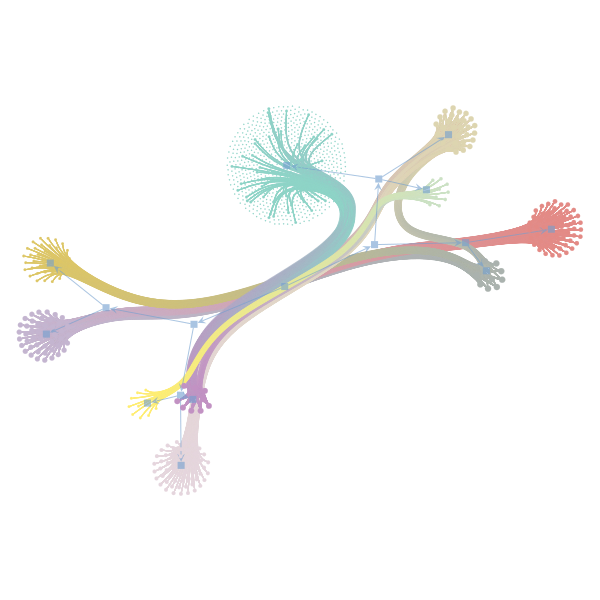

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9c8050c898, at 0x7f9d24713dd8>,
 <Graph object, directed, with 1067 vertices and 1066 edges at 0x7f9d24702ef0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9d24702ef0, at 0x7f9d247027b8>)

In [14]:
from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
min_state = minimize_nested_blockmodel_dl(g_min)
print(min_state)
min_state.draw(layout='sfdp')

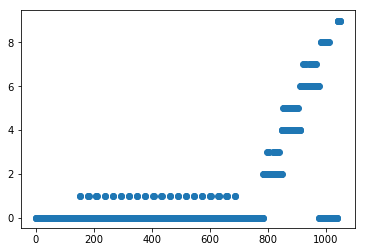

In [15]:
plt.scatter(range(g_min.num_vertices()), min_state.get_bs()[0])